# Auto Encoder

## Load Dataset

In [1]:
DATASET_NAME = 'dataset-5000'
TEST_DATASET_NAME = 'dataset-test'
BATCH_SIZE = 16
MODEL_PATH = 'model/cnn_dropout'

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from util import GeneratedDataset

trainset = GeneratedDataset(DATASET_NAME, transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = GeneratedDataset(TEST_DATASET_NAME, transforms.ToTensor())
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

## Define CNN based auto-encoder

- 64 * 64 * 3 image input = 12,288
- Cov3 with 32 channel, 3 * 3 * 3 * 32 = 864 parameters
- ReLU
- MaxPool -> 32 * 32 * 32 hidden state = 32768
- Cov3 with 64 channel, 32 * 3 * 3 * 64 = 18432 parameters
- ReLU
- MaxPool -> 16 * 16 * 64 hidden state = 16384
- Cov3 with 128 channel, 64 * 3 * 3 * 128 = 73728 parameters
- ReLU
- MaxPool -> 8 * 8 * 128 = 8192 hidden state
- Full connected 8192 -> **embedding size**

And the decoder works reversely.

In [2]:
# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, embedding_size=32, dropout_rate=0.25):
        super(Autoencoder, self).__init__()
        self.embedding_size = embedding_size
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(dropout_rate),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(dropout_rate),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(dropout_rate),
        )
        self.fc1 = nn.Linear(8 * 8 * 128, self.embedding_size)  # Fully connected layer to get 32-length embedding

        # Decoder
        self.fc2 = nn.Linear(self.embedding_size, 8 * 8 * 128)  # Fully connected layer to reshape back to 8x8x128
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Dropout(dropout_rate),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Dropout(dropout_rate),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Dropout(dropout_rate),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1)  # Flatten the tensor
        encoded = self.fc1(encoded)  # Get the embedding
        decoded = self.fc2(encoded)  # Reshape back to 8x8x128
        decoded = decoded.view(decoded.size(0), 128, 8, 8)
        decoded = self.decoder(decoded)
        return decoded, encoded

In [3]:
from util import train_model_steps, plot_model, count_parameters

def train_model(embedding_size=32, dropout_rate=0.25, learning_rate=1e-4, weight_decay=1e-5, num_epochs=20):
    # Initialize the model
    model = Autoencoder(embedding_size=embedding_size, dropout_rate=dropout_rate)
    print(f'Number of parameters: {count_parameters(model)}')

    model, train_losses, test_losses = train_model_steps(model, trainloader, testloader, learning_rate, weight_decay, num_epochs)
    # Save the model
    torch.save(model.state_dict(), f'{MODEL_PATH}/e{embedding_size}.pth')
    plot_model(model, train_losses, test_losses, testset)
    return model, train_losses, test_losses

## Evaluation

Testing with embedding size of (down from 8192)
- 4
- 8
- 16
- 32
- 64

Number of parameters: 407687
Epoch [1/20], Train Loss: 0.2996, Test Loss: 0.2168
Epoch [2/20], Train Loss: 0.1576, Test Loss: 0.1474
Epoch [3/20], Train Loss: 0.1409, Test Loss: 0.1444
Epoch [4/20], Train Loss: 0.1372, Test Loss: 0.1389
Epoch [5/20], Train Loss: 0.1333, Test Loss: 0.1356
Epoch [6/20], Train Loss: 0.1301, Test Loss: 0.1321
Epoch [7/20], Train Loss: 0.1280, Test Loss: 0.1351
Epoch [8/20], Train Loss: 0.1266, Test Loss: 0.1328
Epoch [9/20], Train Loss: 0.1253, Test Loss: 0.1334
Epoch [10/20], Train Loss: 0.1239, Test Loss: 0.1308
Epoch [11/20], Train Loss: 0.1230, Test Loss: 0.1295
Epoch [12/20], Train Loss: 0.1222, Test Loss: 0.1270
Epoch [13/20], Train Loss: 0.1215, Test Loss: 0.1300
Epoch [14/20], Train Loss: 0.1211, Test Loss: 0.1281
Epoch [15/20], Train Loss: 0.1206, Test Loss: 0.1286
Epoch [16/20], Train Loss: 0.1202, Test Loss: 0.1283
Epoch [17/20], Train Loss: 0.1200, Test Loss: 0.1283
Epoch [18/20], Train Loss: 0.1199, Test Loss: 0.1283
Epoch [19/20], Train Loss:

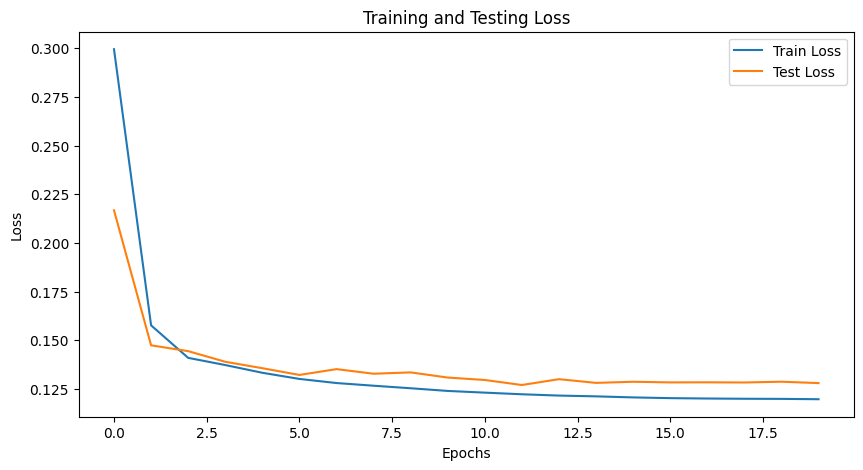

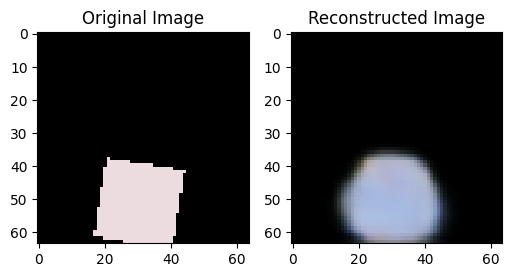

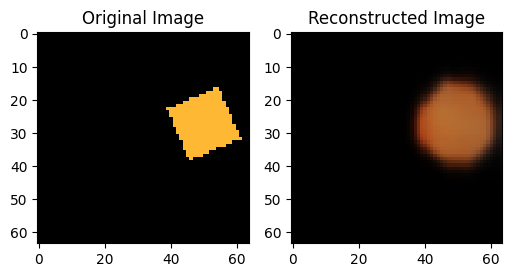

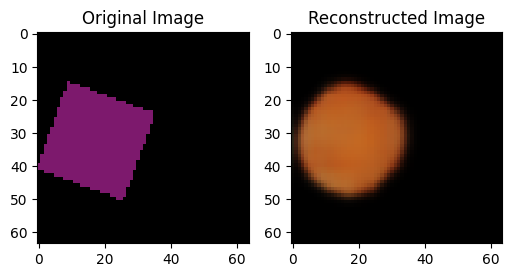

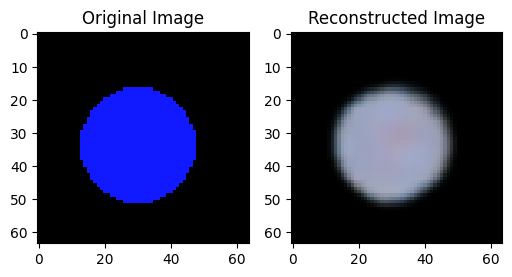

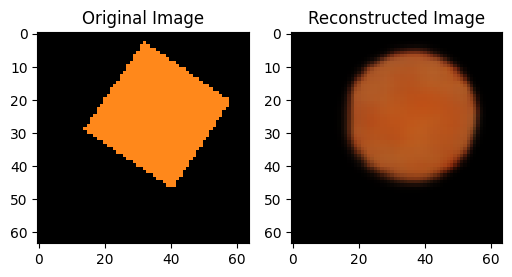

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Dropout(p=0.1, inplace=False)
     (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (5): ReLU()
     (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (7): Dropout(p=0.1, inplace=False)
     (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (9): ReLU()
     (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (11): Dropout(p=0.1, inplace=False)
   )
   (fc1): Linear(in_features=8192, out_features=4, bias=True)
   (fc2): Linear(in_features=4, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')
 

In [4]:
train_model(embedding_size=4, dropout_rate=0.1)

Number of parameters: 473227
Epoch [1/20], Train Loss: 0.2886, Test Loss: 0.1647
Epoch [2/20], Train Loss: 0.1466, Test Loss: 0.1485
Epoch [3/20], Train Loss: 0.1393, Test Loss: 0.1410
Epoch [4/20], Train Loss: 0.1364, Test Loss: 0.1391
Epoch [5/20], Train Loss: 0.1337, Test Loss: 0.1370
Epoch [6/20], Train Loss: 0.1302, Test Loss: 0.1324
Epoch [7/20], Train Loss: 0.1249, Test Loss: 0.1272
Epoch [8/20], Train Loss: 0.1166, Test Loss: 0.1171
Epoch [9/20], Train Loss: 0.1103, Test Loss: 0.1135
Epoch [10/20], Train Loss: 0.1078, Test Loss: 0.1098
Epoch [11/20], Train Loss: 0.1056, Test Loss: 0.1084
Epoch [12/20], Train Loss: 0.1039, Test Loss: 0.1072
Epoch [13/20], Train Loss: 0.1026, Test Loss: 0.1065
Epoch [14/20], Train Loss: 0.1018, Test Loss: 0.1062
Epoch [15/20], Train Loss: 0.1009, Test Loss: 0.1053
Epoch [16/20], Train Loss: 0.1003, Test Loss: 0.1046
Epoch [17/20], Train Loss: 0.1000, Test Loss: 0.1039
Epoch [18/20], Train Loss: 0.0996, Test Loss: 0.1042
Epoch [19/20], Train Loss:

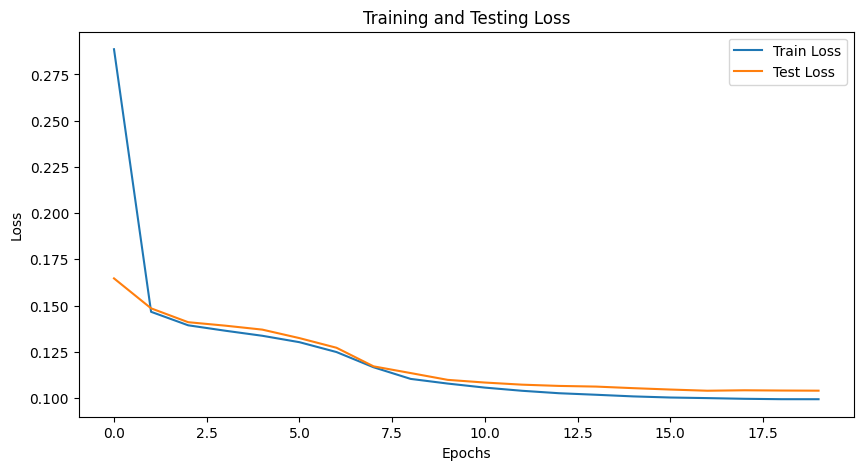

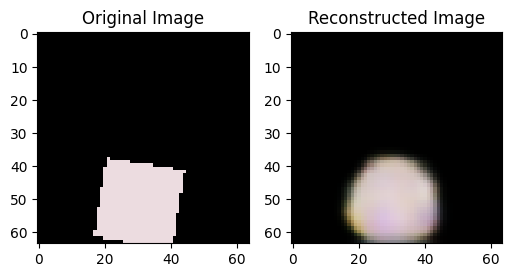

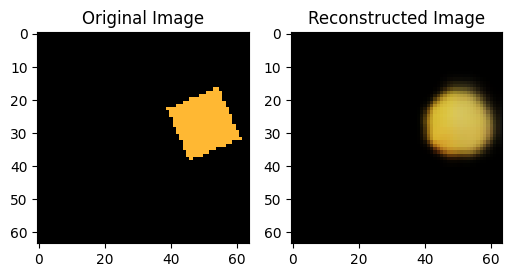

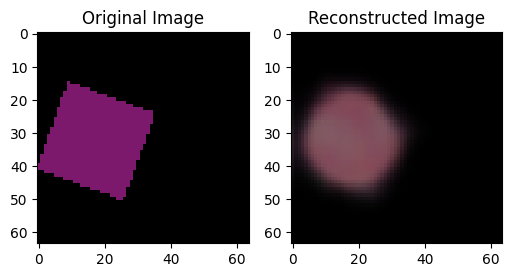

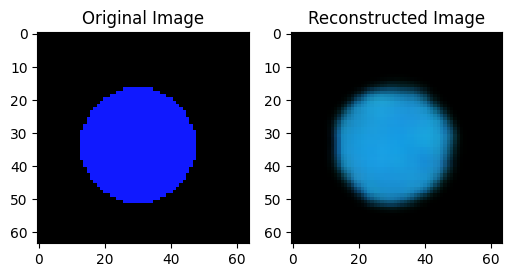

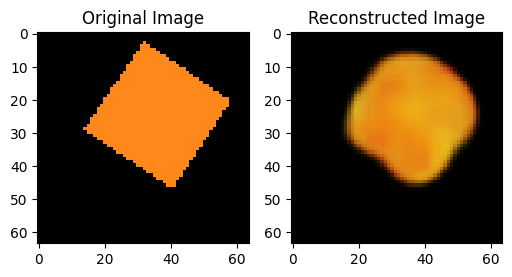

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Dropout(p=0.1, inplace=False)
     (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (5): ReLU()
     (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (7): Dropout(p=0.1, inplace=False)
     (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (9): ReLU()
     (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (11): Dropout(p=0.1, inplace=False)
   )
   (fc1): Linear(in_features=8192, out_features=8, bias=True)
   (fc2): Linear(in_features=8, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')
 

In [5]:
train_model(embedding_size=8, dropout_rate=0.1)

Number of parameters: 604307
Epoch [1/20], Train Loss: 0.3076, Test Loss: 0.2132
Epoch [2/20], Train Loss: 0.1520, Test Loss: 0.1460
Epoch [3/20], Train Loss: 0.1387, Test Loss: 0.1425
Epoch [4/20], Train Loss: 0.1354, Test Loss: 0.1372
Epoch [5/20], Train Loss: 0.1313, Test Loss: 0.1330
Epoch [6/20], Train Loss: 0.1266, Test Loss: 0.1281
Epoch [7/20], Train Loss: 0.1217, Test Loss: 0.1232
Epoch [8/20], Train Loss: 0.1157, Test Loss: 0.1143
Epoch [9/20], Train Loss: 0.1089, Test Loss: 0.1090
Epoch [10/20], Train Loss: 0.1062, Test Loss: 0.1075
Epoch [11/20], Train Loss: 0.1041, Test Loss: 0.1058
Epoch [12/20], Train Loss: 0.1026, Test Loss: 0.1050
Epoch [13/20], Train Loss: 0.1013, Test Loss: 0.1038
Epoch [14/20], Train Loss: 0.1003, Test Loss: 0.1028
Epoch [15/20], Train Loss: 0.0996, Test Loss: 0.1023
Epoch [16/20], Train Loss: 0.0990, Test Loss: 0.1014
Epoch [17/20], Train Loss: 0.0986, Test Loss: 0.1015
Epoch [18/20], Train Loss: 0.0981, Test Loss: 0.1013
Epoch [19/20], Train Loss:

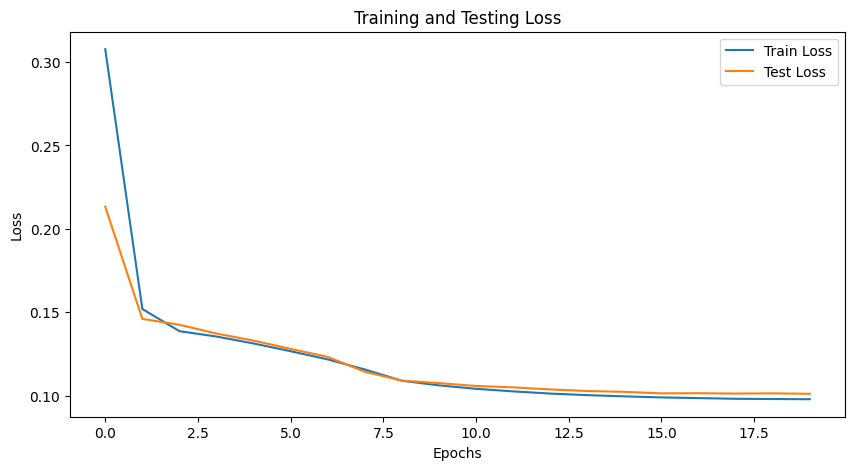

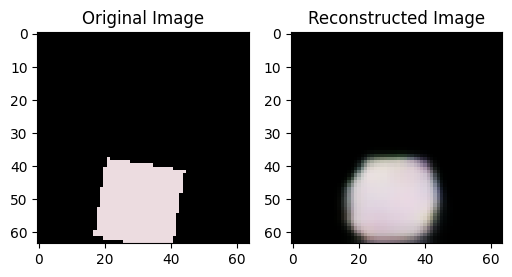

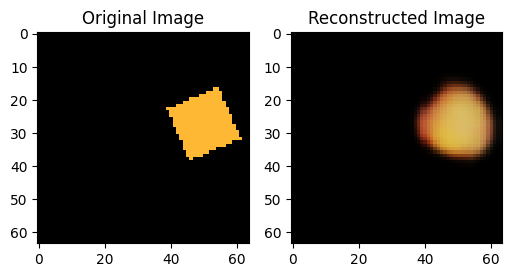

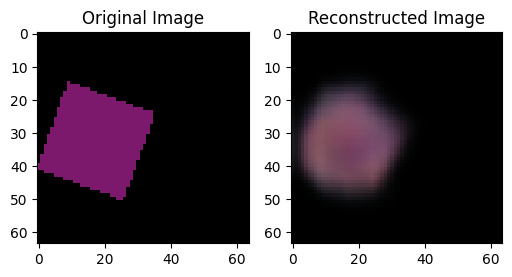

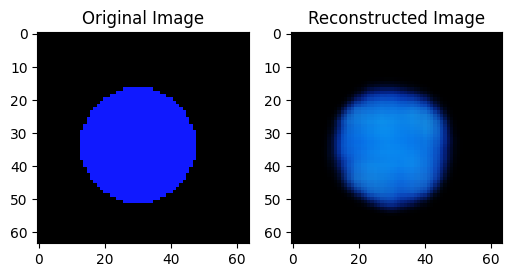

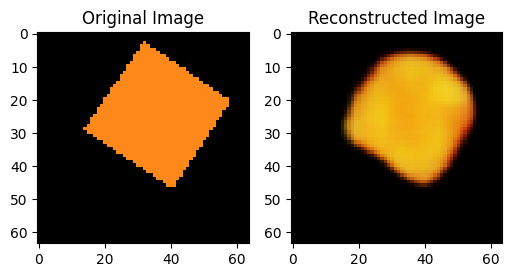

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Dropout(p=0.1, inplace=False)
     (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (5): ReLU()
     (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (7): Dropout(p=0.1, inplace=False)
     (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (9): ReLU()
     (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (11): Dropout(p=0.1, inplace=False)
   )
   (fc1): Linear(in_features=8192, out_features=16, bias=True)
   (fc2): Linear(in_features=16, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')

In [6]:
train_model(embedding_size=16, dropout_rate=0.1)

Number of parameters: 866467
Epoch [1/20], Train Loss: 0.2918, Test Loss: 0.1581
Epoch [2/20], Train Loss: 0.1421, Test Loss: 0.1425
Epoch [3/20], Train Loss: 0.1353, Test Loss: 0.1384
Epoch [4/20], Train Loss: 0.1310, Test Loss: 0.1328
Epoch [5/20], Train Loss: 0.1260, Test Loss: 0.1284
Epoch [6/20], Train Loss: 0.1184, Test Loss: 0.1180
Epoch [7/20], Train Loss: 0.1095, Test Loss: 0.1102
Epoch [8/20], Train Loss: 0.1051, Test Loss: 0.1067
Epoch [9/20], Train Loss: 0.1025, Test Loss: 0.1053
Epoch [10/20], Train Loss: 0.1005, Test Loss: 0.1045
Epoch [11/20], Train Loss: 0.0987, Test Loss: 0.1020
Epoch [12/20], Train Loss: 0.0970, Test Loss: 0.1009
Epoch [13/20], Train Loss: 0.0958, Test Loss: 0.0991
Epoch [14/20], Train Loss: 0.0946, Test Loss: 0.0985
Epoch [15/20], Train Loss: 0.0937, Test Loss: 0.0977
Epoch [16/20], Train Loss: 0.0927, Test Loss: 0.0967
Epoch [17/20], Train Loss: 0.0919, Test Loss: 0.0961
Epoch [18/20], Train Loss: 0.0915, Test Loss: 0.0959
Epoch [19/20], Train Loss:

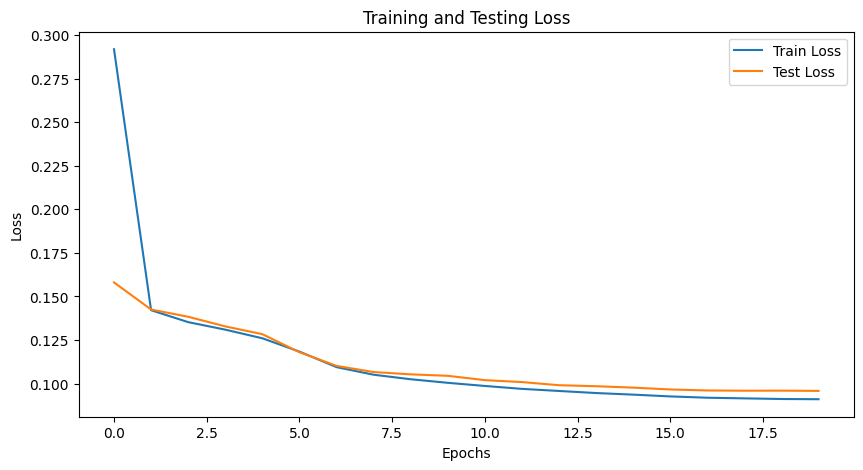

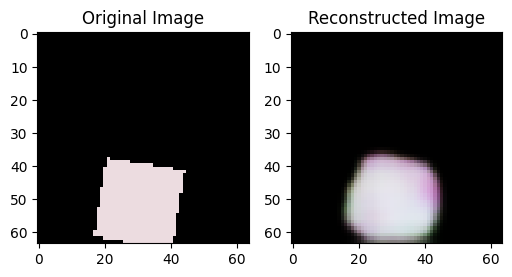

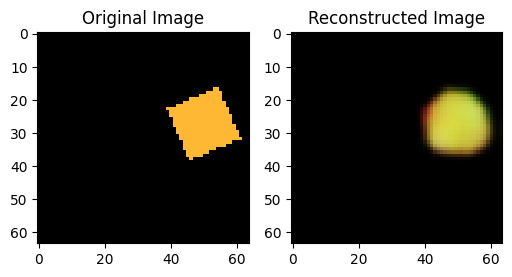

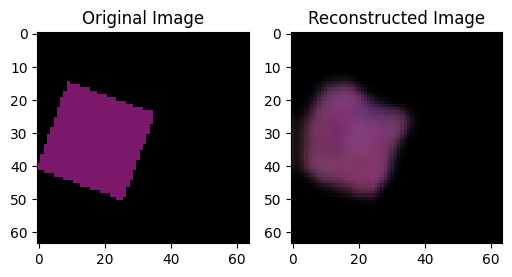

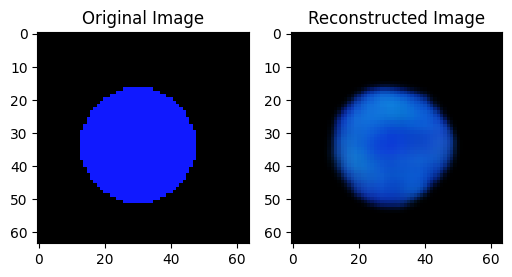

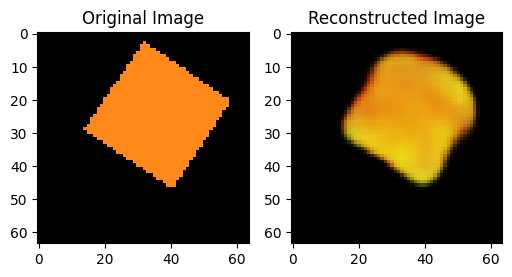

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Dropout(p=0.1, inplace=False)
     (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (5): ReLU()
     (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (7): Dropout(p=0.1, inplace=False)
     (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (9): ReLU()
     (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (11): Dropout(p=0.1, inplace=False)
   )
   (fc1): Linear(in_features=8192, out_features=32, bias=True)
   (fc2): Linear(in_features=32, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')

In [7]:
train_model(embedding_size=32, dropout_rate=0.1)

Number of parameters: 1390787
Epoch [1/20], Train Loss: 0.2808, Test Loss: 0.1577
Epoch [2/20], Train Loss: 0.1424, Test Loss: 0.1430
Epoch [3/20], Train Loss: 0.1361, Test Loss: 0.1392
Epoch [4/20], Train Loss: 0.1310, Test Loss: 0.1319
Epoch [5/20], Train Loss: 0.1238, Test Loss: 0.1251
Epoch [6/20], Train Loss: 0.1148, Test Loss: 0.1124
Epoch [7/20], Train Loss: 0.1069, Test Loss: 0.1077
Epoch [8/20], Train Loss: 0.1030, Test Loss: 0.1050
Epoch [9/20], Train Loss: 0.1002, Test Loss: 0.1028
Epoch [10/20], Train Loss: 0.0977, Test Loss: 0.1003
Epoch [11/20], Train Loss: 0.0955, Test Loss: 0.0989
Epoch [12/20], Train Loss: 0.0935, Test Loss: 0.0971
Epoch [13/20], Train Loss: 0.0920, Test Loss: 0.0958
Epoch [14/20], Train Loss: 0.0904, Test Loss: 0.0948
Epoch [15/20], Train Loss: 0.0894, Test Loss: 0.0949
Epoch [16/20], Train Loss: 0.0886, Test Loss: 0.0932
Epoch [17/20], Train Loss: 0.0879, Test Loss: 0.0929
Epoch [18/20], Train Loss: 0.0876, Test Loss: 0.0926
Epoch [19/20], Train Loss

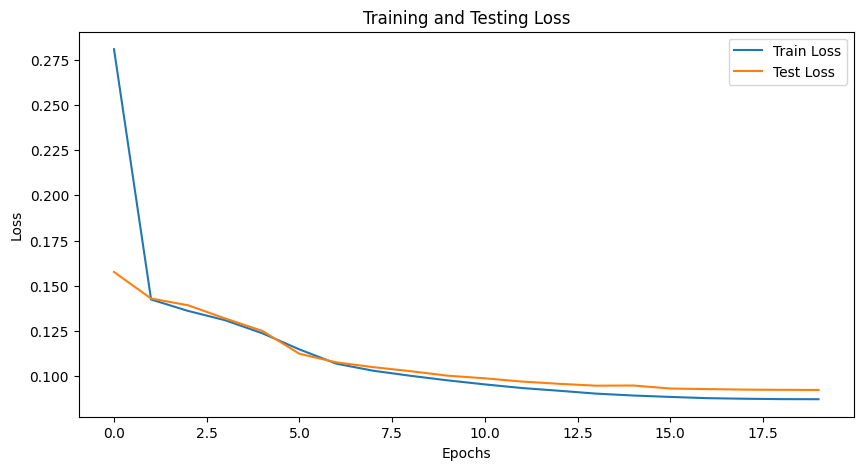

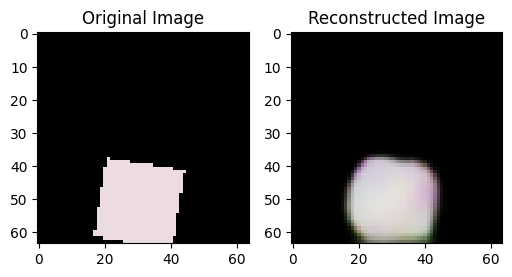

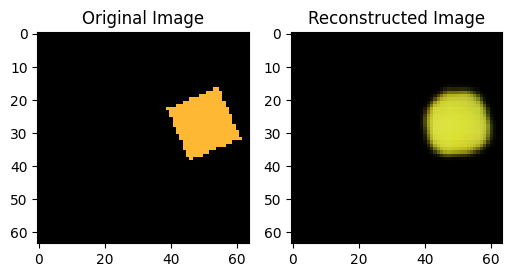

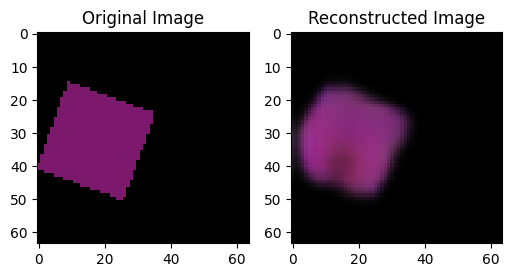

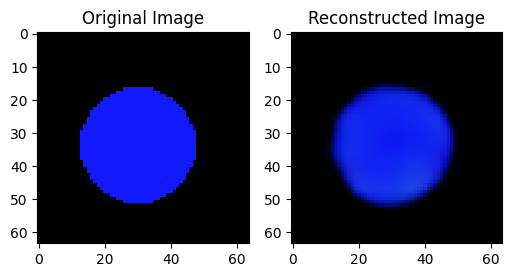

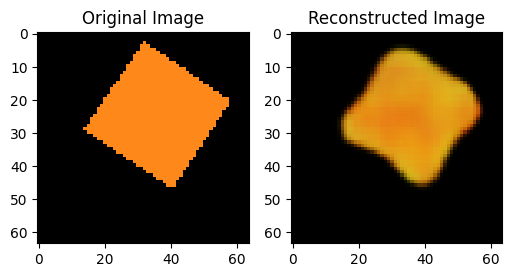

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Dropout(p=0.1, inplace=False)
     (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (5): ReLU()
     (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (7): Dropout(p=0.1, inplace=False)
     (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (9): ReLU()
     (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (11): Dropout(p=0.1, inplace=False)
   )
   (fc1): Linear(in_features=8192, out_features=64, bias=True)
   (fc2): Linear(in_features=64, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')

In [8]:
train_model(embedding_size=64, dropout_rate=0.1)